In [11]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

torch.manual_seed(1)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
rootPath = '/content/gdrive/MyDrive/Colab Notebooks/project/geoguessr'

if not os.path.isdir(rootPath):
  os.makedirs(rootPath)

train_path = rootPath+'/train_set'
test_path = rootPath+'/test_set'
valid_path = rootPath+'/validation_set'

if not os.path.isdir(train_path):
  os.makedirs(train_path)

if not os.path.isdir(test_path):
  os.makedirs(test_path)

if not os.path.isdir(valid_path):
  os.makedirs(valid_path)


Mounted at /content/gdrive


In [37]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as datasets
#seems the default size is 1536 x 662 from Kaggle

dataset_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

geoguessr = '/content/gdrive/MyDrive/Colab Notebooks/project/geoguessr'
train_path = geoguessr+'/train_set'
test_path = geoguessr+'/test_set'
valid_path = geoguessr+'/validation_set'

dataset = datasets.ImageFolder(root=geoguessr, transform=dataset_transforms)

train_dataset = torchvision.datasets.ImageFolder(train_path,transform=dataset_transforms)
val_dataset = torchvision.datasets.ImageFolder(valid_path,transform=dataset_transforms)
test_dataset = torchvision.datasets.ImageFolder(test_path,transform=dataset_transforms)

batch_size = 30;
num_workers = 0;

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

print("Done")

Done


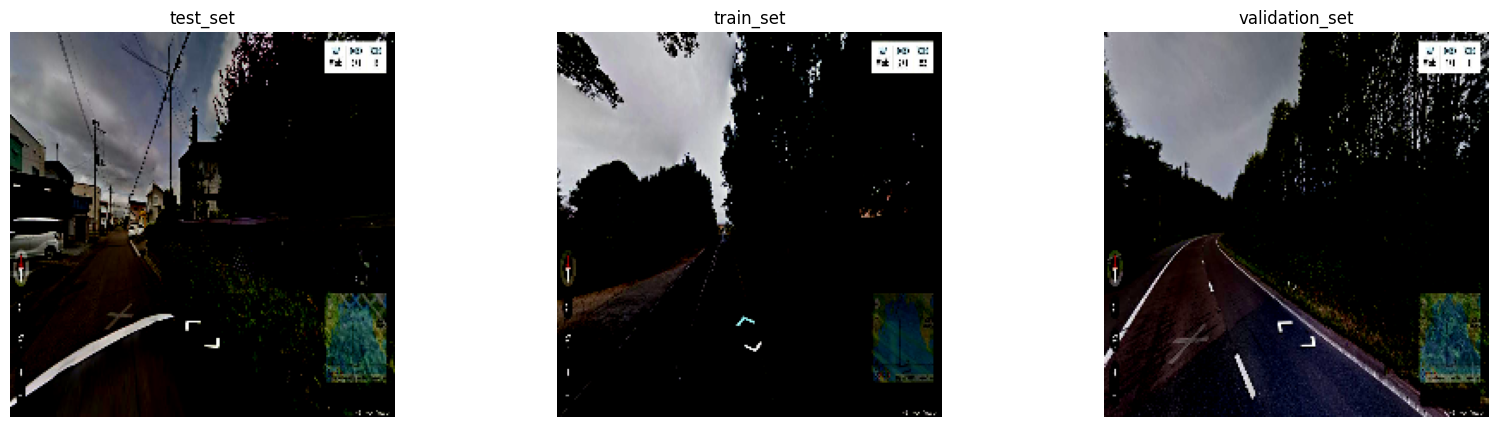

Number of training images: 2941
Number of validation images: 979
Number of testing images: 979


In [38]:
# import matplotlib.pyplot as plt
# import numpy as np
classes = dataset.classes
fig, axis = plt.subplots(1, len(classes), figsize=(20, 5))

for i in range(len(classes)):
    # Get the indices of the images that belong to the current class
    indices = np.where(np.array(dataset.targets) == i)[0]
    # Choose a random index from the indices
    idx = np.random.choice(indices)
    # Get the corresponding image and label
    img, label = dataset[idx]
    # Plot the image and label it with the class name
    axis[i].imshow(img.permute(1, 2, 0))
    axis[i].set_title(classes[label])
    axis[i].axis("off")

plt.show()

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

In [3]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [4]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [5]:
def train(model, train_loader, valid_loader, batch_size=32, learning_rate = 0.001, num_epochs=30):
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy Loss and the optimizer will be Adam
    # These two were selected because:
    # Cross Entropy Loss - Penalizes the model more heavily when it makes larger errors, which is desirable for image classification
    # Adam - Converges faster than other optimization algorithms, which is important for large-scale image classification
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    ########################################################################
    # Set up some numpy arrays to store the training/test accuracy
    train_acc = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    print ("Training Started...")
    n = 0 # Iteration number
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_images = 0
        for imgs, labels in iter(train_loader):
            
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            # Forward pass, backward pass, and optimize
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            # Zero the parameter gradients
            optimizer.zero_grad()
            n += 1          
        
        # Get accuracy
        train_acc[epoch] = get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, valid_loader)

        print(("Epoch {}: Train acc: {} |" + "Validation acc: {}").format(epoch, train_acc[epoch], val_acc[epoch]))

        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)
            
    epochs = np.arange(1, num_epochs + 1)

    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    return train_acc, val_acc, epochs
     

In [6]:
def plot_curve(acc, epochs, curve_name):
  plt.plot(epochs, acc)
  plt.title(curve_name + " Curve (Default Parameters)")
  plt.xlabel("Epochs")
  plt.ylabel(curve_name + " Accuracy")
  plt.show()
  return

In [7]:
!nvidia-smi

Sun Apr  2 22:24:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
class TransferModel(nn.Module):
    def __init__(self):
        super(TransferModel, self).__init__()
        self.name = "transfer"
        efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
        self.features = nn.Sequential(*list(efficientnet.children())[:-1])
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.4),
            nn.Linear(in_features=1280, out_features=5)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
     

In [40]:
efficientnet = torchvision.models.efficientnet_b0(pretrained=True)
efficientnet

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

CUDA Available, training on CUDA
Training Started...
Epoch 0: Train acc: 0.7429445766746005 |Validation acc: 0.6332992849846782
Epoch 1: Train acc: 0.8129887793267596 |Validation acc: 0.6792645556690501
Epoch 2: Train acc: 0.8860931655899354 |Validation acc: 0.7119509703779366
Epoch 3: Train acc: 0.8871132267936076 |Validation acc: 0.6813074565883555
Epoch 4: Train acc: 0.940156409384563 |Validation acc: 0.7150153217568948
Epoch 5: Train acc: 0.9503570214212853 |Validation acc: 0.72829417773238
Epoch 6: Train acc: 0.9421965317919075 |Validation acc: 0.7099080694586313
Epoch 7: Train acc: 0.9670180210812649 |Validation acc: 0.7160367722165475
Epoch 8: Train acc: 0.9540972458347501 |Validation acc: 0.6833503575076609
Epoch 9: Train acc: 0.967698061883713 |Validation acc: 0.7262512768130746
Epoch 10: Train acc: 0.9649778986739205 |Validation acc: 0.7150153217568948
Epoch 11: Train acc: 0.9782386943216593 |Validation acc: 0.7293156281920327
Epoch 12: Train acc: 0.9656579394763686 |Validati

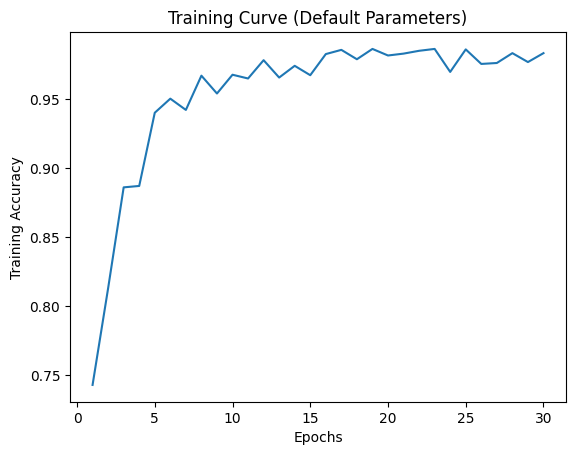

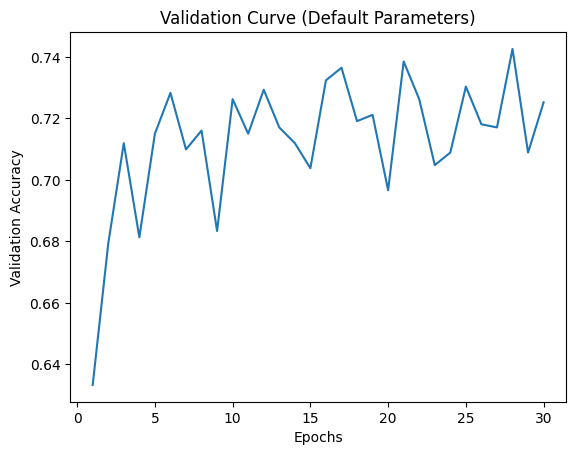

In [43]:
model_transfer = TransferModel()
if torch.cuda.is_available():
    print("CUDA Available, training on CUDA")
    model_transfer.cuda()
train_acc_transfer, val_acc_transfer, epochs_transfer = train(model_transfer, train_loader, valid_loader)
plot_curve(train_acc_transfer, epochs_transfer, "Training")
plot_curve(val_acc_transfer, epochs_transfer, "Validation")